# Quantitative Methods in Finance

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantMethodsFinance/blob/main/NOTEBOOKS/2_Interest_rates_basics.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.

Import some libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Interest rate 

Given the following:

| Concept | Amount | 
|----------|----------|
| Initial investment    | 100     |
| Final value    | 150     |
| T-t (years)    | 5     |

Calculate simple, compounded and continuously compounded interest


In [3]:
# Your code here

## Continuously compounded interest

Check numerically that:

$$\lim_{n \to \infty}\left(1+r\frac{T-t}{n}\right)^n=\exp\left(r\left(T-t\right)\right)$$

Assume $r=0.03$ $T-t=5$

In [4]:
# Your code here

## Internal rate of return / yield of a bond 

A bond pays a coupon of 3%, has a 10 year maturity and trades at a price of 105%. Compute its yield.

In [9]:
# Your code here

from enum import Enum

class freq_options(Enum):
    QUARTERLY = 1
    SEMI_ANNUAL = 2
    ANUAL = 3


def bond_price(TTM, coupon, y, freq):

    if freq == freq_options.QUARTERLY:
          delta = 0.25
    elif freq == freq_options.SEMI_ANNUAL:
        delta = 0.5
    elif freq == freq_options.ANUAL:
        delta = 1
    else:
        raise ValueError("Invalid frequency")
    
    periods = int(TTM / delta)

    payment_times = np.arange(TTM,0, step=-delta)

    return np.sum(coupon * delta * np.exp(-y * payment_times)) + np.exp(-y * TTM)



In [12]:
bond_price(5,0.03,0.05,freq_options.ANUAL)

0.9082299737247383

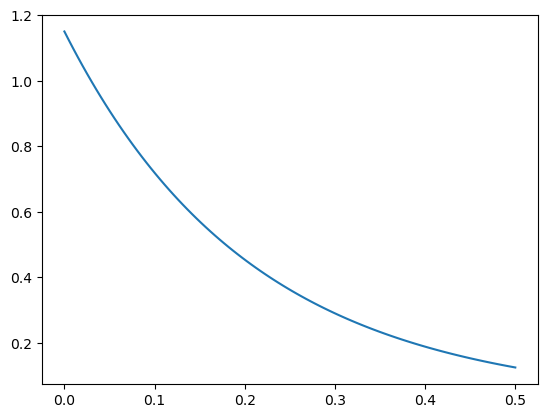

In [15]:
y = np.linspace(0,0.5,100)

p = [bond_price(5,0.03,yi,freq_options.ANUAL) for yi in y]


plt.plot(y,p)

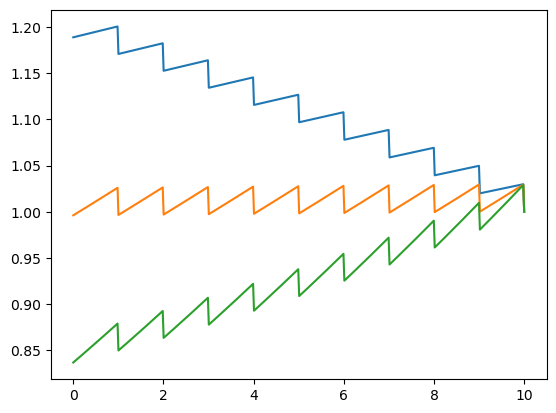

In [20]:
ttm = np.linspace(0,10,500)

p1 = [bond_price(t,0.03,0.01,freq_options.ANUAL) for t in ttm]
p2 = [bond_price(t,0.03,0.03,freq_options.ANUAL) for t in ttm]
p3 = [bond_price(t,0.03,0.05,freq_options.ANUAL) for t in ttm]



plt.plot(10-ttm,p1)
plt.plot(10-ttm,p2)
plt.plot(10-ttm,p3)